# Covid-19 Türkiye Analizi (Plotly kütüphanesi ile görselleştirilmesi)

Covid-19 Virüsünün Türkiye'deki sürecini gösteren bu notebook aynı zamanda plotly kütüphanesinin kullanımı üzerinde okuyanlar için pratik olacaktır.

Veriler bilgileri güncel değildir. 19 Ağustos son veri tarihi ancak zamanla güncellencektir.

**Son Güncelleme 1 Eylül**

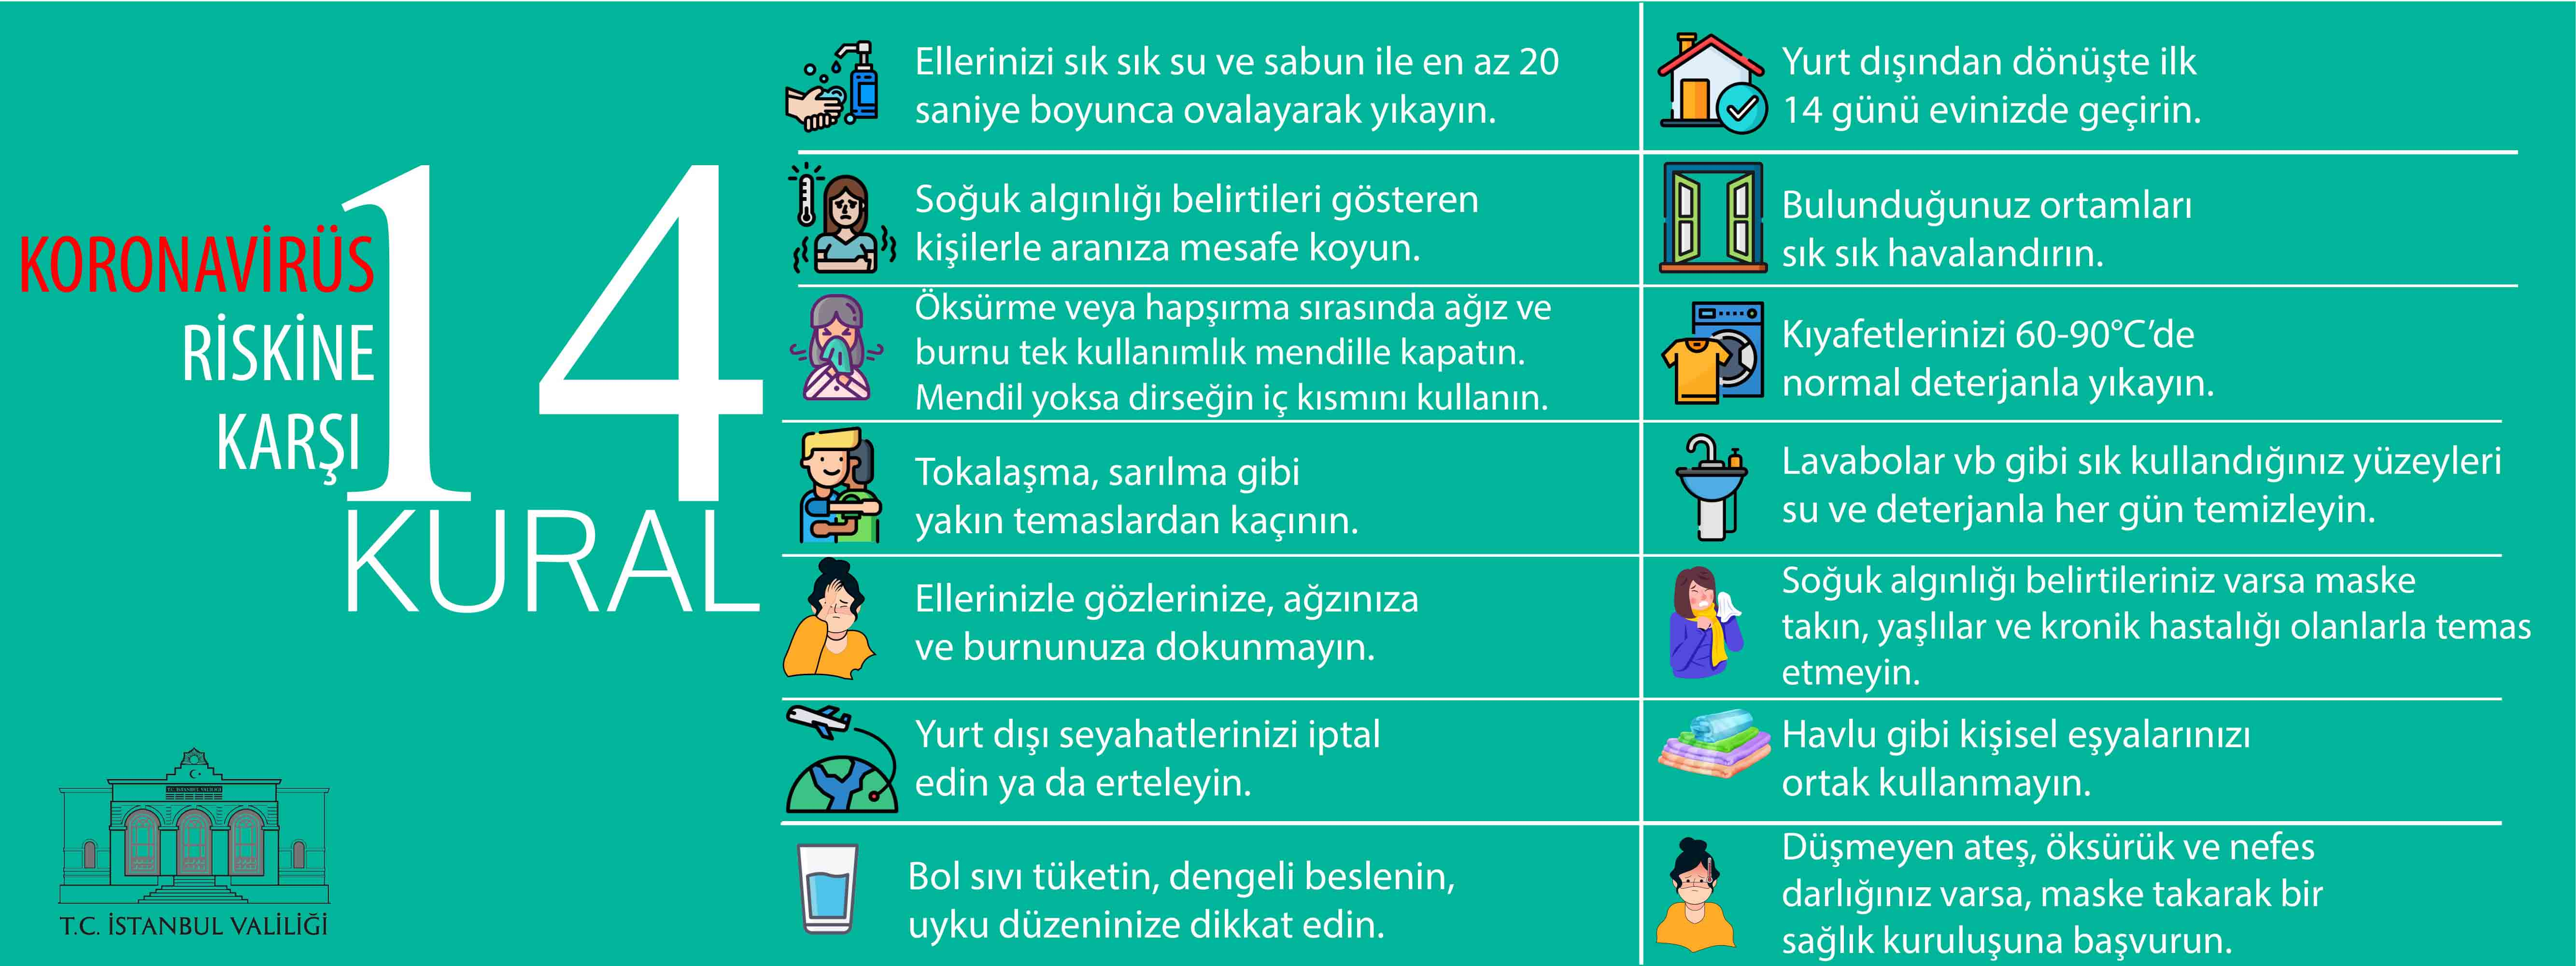

In [ ]:
#import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
from scipy.signal import find_peaks_cwt
import plotly.express as px
import plotly.io

In [ ]:
#set some display modifications 
%matplotlib inline
rcParams['figure.figsize'] = 8,11
#plt.style.use('seaborn-whitegrid')
pd.set_option('display.max_rows', 162)

In [ ]:
#dailydata = pd.read_csv('Covid-19/TurkeyCovid19Dataset.csv')
datatr = pd.read_csv('../input/covid19-in-turkey/covid_19_data_tr.csv')
test_numbers = pd.read_csv('../input/covid19-in-turkey/test_numbers.csv')
#confirmed = pd.read_csv('Covid-19/time_series_covid_19_confirmed_tr.csv')
intubated = pd.read_csv('../input/covid19-in-turkey/time_series_covid_19_intubated_tr.csv')


In [ ]:
#Drop unnecesary columns
intubated.drop(['Province/State', 'Lat','Long','Country/Region'], axis=1, inplace=True)
#Convert ıntubated dataset from wider to longer for add general dataset
intubated = intubated.unstack().reset_index()
intubated = intubated.rename(columns={0:'Intubated'})
intubated.drop(['level_1','level_0'],axis=1, inplace=True)
intubated.tail()

In [ ]:
#Drop unnecesary columns
test_numbers.drop(['Province/State', 'Lat','Long','Country/Region'], axis=1, inplace=True)
#Convert test numbers dataset from wider to longer for add general dataset
test_numbers = test_numbers.unstack().reset_index()
test_numbers = test_numbers.rename(columns={0:'Test_numbers'})
test_numbers.drop(['level_1','level_0'],axis=1, inplace=True)
test_numbers.tail()

In [ ]:
#Drop unnecesary columns
datatr.drop(['Province/State','Country/Region'], axis=1, inplace=True)
datatr.tail()

In [ ]:
#Change columns order
cols = ['Test_numbers', 'Confirmed','Deaths','Recovered','Intubated','Last_Update']
df = pd.concat([datatr, test_numbers, intubated], axis=1)
df = df[cols]
df.tail()

In [ ]:
#Date was string, convert it into DateTime and set index
df.set_index('Last_Update', inplace=True)
df.index = pd.to_datetime(df.index)
df.tail()

In [ ]:
#In dataset value in Confirmed, Deaths and Recovered are aggregated, not daily
#In this piece of codes make Daily value for each day
df['DailyConfirmed'] = pd.DataFrame(df['Confirmed'].diff().fillna(0).astype(int))
df['DailyDeaths'] = pd.DataFrame(df['Deaths'].diff().fillna(0).astype(int))
df['DailyRecovered'] = pd.DataFrame(df['Recovered'].diff().fillna(0).astype(int))

In [ ]:
#Added new value until 31 September
# yeniveri = pd.read_csv("Dataset/güncelveri.txt")
# yeniveri.set_index('Last_Update', inplace=True)
# yeniveri.index = pd.to_datetime(yeniveri.index)

In [ ]:
#concatted old dataframe
#df = pd.concat([df,yeniveri])

In [ ]:
#Intubated number for each day but when increase
#below 0 is eliminated
df['DailyIntubated'] = pd.DataFrame(df['Intubated'].diff().fillna(0).astype(int))
df['DailyIntubated'] = df['DailyIntubated'].apply(lambda x: 0 if x<0 else x)

In [ ]:
#Difference of Intubated number
df['General DailyIntubated'] = pd.DataFrame(df['Intubated'].diff().fillna(0).astype(int))

In [ ]:
#with diff function first row in DailyConfirmed was eliminated
#it was fixed
df['DailyConfirmed'][0] = 1

In [ ]:
#Made additional columns
df['Total Death/Recovered'] = pd.DataFrame(((df['Deaths'] / df['Recovered']) ).replace([np.inf, -np.inf], np.nan).fillna(0))
df['Total Death/Recovered'] = pd.DataFrame(((df['Deaths'] / df['Recovered']) ).replace([np.inf, -np.inf], np.nan).fillna(0))
df['Total Confirmed/Recovered'] = pd.DataFrame(((df['Confirmed'] / df['Recovered']) ).replace([np.inf, -np.inf], np.nan).fillna(0))
df['Daily Death/Recovered'] = pd.DataFrame(((df['DailyDeaths'] / df['DailyRecovered']) ).replace([np.inf, -np.inf], np.nan).fillna(0))
df['Daily Confirmed/Recovered'] = pd.DataFrame(((df['DailyConfirmed'] / df['DailyRecovered'])).replace([np.inf, -np.inf], np.nan).fillna(0))
df['Daily Intubated/Recovered'] = pd.DataFrame(((df['DailyIntubated'] / df['DailyRecovered'])).replace([np.inf, -np.inf], np.nan).fillna(0))
df['Daily Death/Intubated'] = pd.DataFrame(((df['DailyDeaths'] / df['DailyIntubated'])).replace([np.inf, -np.inf], np.nan).fillna(0))
df['Daily Confirmed/Test'] = pd.DataFrame(((df['DailyConfirmed'] / df['Test_numbers'])).replace([np.inf, -np.inf], np.nan).fillna(0))

Kaggle'da bulunan mevcut datasetleri kullanıp yeni sütunlar ekleyip ve temizleyip kendi datasetimi oluşturdum. Direkt buradan başlamak istemedim hem diğer dataseti hazırlayan arkadaşların emeklerine saygı açısından hem de okuyanlar için veri temizliğine pratik olması açısından iyi olacağını düşündüm.

In [ ]:
df = pd.read_csv("../input/covid19turkey-dataset/31SeptData.csv")
df.set_index('Last_Update', inplace=True)
df.index = pd.to_datetime(df.index)
df.tail(10)

Datasetimizdeki bütün parametreleri zaman serisi şekilde hızlı bir bakış için matplotlibteki `plot()` fonksiyonunu kullanalım.

In [ ]:
#Quick overview all parameters by date
df.plot(subplots=True)
plt.show()

Veriseti iyice temizlendikten ve düzene girdikten sonra birkaç parametreyi detaylıca inleceyecek olursak eğer;
Günlük Vaka sayısının zaman içindeki değişimini aşağıdaki çizgi grafiğinde görebiliriz. Bunun için `plotly.express.line()` fonksiyonunu kullanıyoruz.
Bu fonksiyon içindeki opsiyonel parametreleri de girerek daha okunaklı ve anlaşılır bir grafik elde etmiş oluruz.
Grafiğe bakacak olursak günlük vaka sayısı ülkeye girişinden sonra istikrarlı bir şekilde artmaya başlamış 11 Nisan Günü zirve noktkasına ulaşmış.
Daha sonra azalma görülüyor ancak bu azalma düzenli değil. 19 Mayıs itibariyle vaka sayısı bin civarında değişiyor. 
Alınan önlemlerin ne derece etkili olduğu grafikte açıkça görülüyor.

In [ ]:
#Plotting confirmed number
confirmed_fig = px.line(x=df.index,y=df['DailyConfirmed'], color=px.Constant("Daily Confirmed"),
             labels=dict(x="Date", y="# of Daily Confirmed", color="Time Period"),
            title = 'Daily Confirmed Trend').update_layout(plot_bgcolor='aqua')
confirmed_fig.show()

Hemen alttaki grafikte ise iki farklı grafiğin birleşimini görüyoruz. Çizgi grafiği günlük vefat eden sayısının gösterirken nokta grafiği şeklinde olan grafik ise günlük entübe hasta başına vefat eden sayısı göstermektedir. Özellikle 20 Nisan günü açıklana sayılara göre bu değer 61.5 ile en üst seviyeye çıkmış daha sonra azalmaya başlamıştır. İkinci bir grafik eklemek için `plotly.express.line.add_scatter()` fonksiyonu kullanıldı.

In [ ]:
#Plotting deaths number
death_fig = px.line(x=df.index,y=df['DailyDeaths'], color=px.Constant("Daily Deaths"),
             labels=dict(x="Date", y="# of Daily Deaths", color="Time Period"),
            title = 'Daily Deaths Trend')
death_fig.add_scatter(x=df.index,y=df['Daily Death/Intubated'], name="Daily Death/Intubated")
death_fig.show()

Aynı grafik türü ancak iki farklı parametrenin karşılaştırılmasını gösteren aşağıda grafikte ise günlük vaka sayısının günlük iyileşen sayısına oranı ile günlük vefat eden sayısının günlük entübe hasta sayısına oranını görülmektedir. Özellikle günlük vaka sayısının günlük iyileşen sayısına oranının "1"'in altında olması salgının kontrol altında olduğunu bize söylemektedir.

In [ ]:
#Confirmed-Recovered ratio and Deaths-Intubated ratio is important
#It shows us how was going pandemic what is trend
#for to say pandemic under control Confirmed-Recovered ratio should be under one is required
daily_con_rec_death_int = px.line(x=df.index,y=df['Daily Confirmed/Recovered'], color=px.Constant("Daily Confirmed/Recovered"),
             labels=dict(x="Date", y="Daily Ratio", color="Time Period"),
            title = 'Daily Confirmed/Recovered and Death/Intubated Ratio Trend')
daily_con_rec_death_int.add_scatter(x=df.index,y=df['Daily Death/Intubated'], name="Daily Death/Intubated")
daily_con_rec_death_int.show()

Aşağıdaki grafikte ise her gün yeni oluşan entübe hasta sayısının çizgi grafiği görülmektedir. Süreç içerisinde 2 defa zirve noktayı gören (28 Mart ve 29 Temmuz) bu değer bize özellikle yaşlı ve kronik hastalığı olan toplum fertlerinin bu salgınla olan mücadelesini göstermektedir.

In [ ]:
#plotting number of intubated for each day which has increase
int_num_fig = px.line(x=df.index,y=df['DailyIntubated'], color=px.Constant("# of Intubated"),
             labels=dict(x='Date', y="# of intubated", color="Time Period"),
                title = '# of Intubated')
int_num_fig.show()

Sütun ve çizgi grafiğinin bir arada kullanıldığı aşağıdaki görselde ise test sayısı ile günlük vaka sayısı arasındaki korelasyonu göstermektedir. Başlangıçta az olan test sayısı belirli bir süre zarfında 20000 ile 50000 arasında değişirken özellikle 4 Ağustostan itibaren hızlı şekilde arttığını 19 Ağustosta zirve noktaya ulaştığını görüyoruz.
Sütun grafiği için `plotly.express.line.add_bar()` fonksiyonu kullanıldı.

In [ ]:
#plotting number of test and number of confirmed patients 
fig = px.line(x=df.index,y=df['DailyConfirmed'], color=px.Constant("Daily Confirmed"),
             labels=dict(x="Date", y="# of Test and Confirmed", color="Time Period"),
            title = 'Number of test and confirmed')
fig.add_bar(x=df.index,y=df['Test_numbers'], name="Test Numbers")
fig.show()

Aşağıdaki sütun grafiğinde ise entübe hasta sayısındaki değişim görülmektedir. 2 üstteki çizgi grafiğinin aksine bu grafikte azalan entübe hasta sayısı da görülmektedir. 11 Nisanda başlayan eksi yönde artma 3 Hazirana kadar devam edip daha sonra azalıp artan bir görüntü oluşmaktadır. 29 Temmuz'da ikinci zirve noktayı görüp tekrar azalmakta ancak eksiye neredeyse hiç düşmediği görülüyor.

In [ ]:
#Plotting intubated patients number day by day
int_fig = px.bar(x=df.index,y=df['General DailyIntubated'], color=px.Constant("# of Intubated"),
             labels=dict(x='Last_Update', y="Intubated Trend", color="Time Period"),
                title = 'Intubated Trend day by day').update_layout(plot_bgcolor = 'gray')
int_fig.show()

Entübe hasta sayısındaki başlangıçtaki artış, virüsün ülke içerisine yeni girmesi ve kuluçka süresi boyunca belirti göstermeden hızla yayılmasıyla özellikle kronik hasta ve 65 yaş ve üzeri insanlar üzerindeki etkisini ciddi ölçüde göstermiştir. Daha sonraki yavaşça düşüş ve 3 Hazirana kadar entübe sayısındaki negatif trend sağlık çalışanlarının üstün gayreti ve diğer ülkelerden edinilen hastaya yaklaşım tecrübeleri sayesinde gerçekleşmiştir. 25 Temmuza kadar geçen aralıkta ise eksi ve artı yönde değişkenlik göstermiştir.

In [ ]:
#Plotting intubated patients number day by day
dailyTestConf = px.line(x=df.index,y=df['Daily Confirmed/Test']*100,
             labels=dict(x='Last_Update', y="Daily Confirmed/Test Ratio"),
                title = 'Daily Confirmed/Test Ratio Trend').update_layout(plot_bgcolor = 'cornsilk')
dailyTestConf.show()

Test başına vaka sayısı 27 Martta zirve noktayı **(%27)** görmüşken zamanla giderek azalmıştır. 31 Ağustos son veri günü bu oran **%1.41**'dir.

In [ ]:
#Türkiye GeoJSON dosyası https://github.com/cihadturhan/tr-geojson adresinden alınmıştır.
import json
with open('../input/trcitiesgeojson/tr-cities-utf8.json', encoding="utf-8") as response:
    counties = json.load(response)
counties["features"][0]

In [ ]:
eachcitydf = pd.read_csv('../input/number-of-cases-in-the-city-covid19-turkey/number_of_cases_in_the_city.csv')
#Listede 'id' sütunu yoktu Geojson ile eşleştirme yapmak için gerekli.
eachcitydf["id"] = list(range(1,82))
eachcitydf["id"] = eachcitydf["id"].astype(str)

In [ ]:
#Turkey map
#Şehir Şehir korona virüs vaka sayısı güncel değildir.
#Sadece 'choropleth' ile etkileşimli harita nasıl yapılır gösterilmek için yapılmıştır.
import plotly.express as px
fig = px.choropleth(eachcitydf, geojson=counties, color='Number of Case',
                            color_continuous_scale="Viridis_R",            
                            range_color=(0,300),
                            locations = "id", #GeoJson ile eşleşecek anahtar kelime
                            scope="asia",
                            labels={'Number of Case':'# of Case'},
                            #featureidkey="properties.name",
                            center = {"lat": 39.925533, "lon": 32.866287},
                            projection="mercator",)

fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.update_geos(fitbounds="locations", visible=False) #Komşu ülkeler görünmez hale getirilip lokasyonlar odak hale getirildi.
fig.show()

Güncel veri olmasa dâhi Türkiye'nin başlıca büyükşehirlerdeki vaka sayılarının diğer şehirlere nazaran ne kadar fazla olduğu rahatlıkla görülebilir. Bunun nedenlerini hepimiz az çok biliyoruzdur ancak söylemek gerekir ise; bu şehirlerin nüfus yoğunluğu olarak diğer şehirlere göre daha fazla olması, yapılaşmanın sık ve içe içe olması, alışveriş, ticaret ve diğer hizmet sektörlerinin fazla olması, toplu taşımanın toplum içinde sık kullanılan bir ulaşım yönteminin olması bulaşıcı özelliğinin fazla olduğu bilinen Covid-19 virüsü için çok iyi bir  ortam hazırlamaktadır.

In [ ]:
#* 23/08/2020 tarihi dahil toplam sayı, ** 17/08/2020 – 23/08/2020 tarihleri arasındaki toplam sayı
regiondf = pd.read_csv('../input/ibbs1-covid19-turkey/blgeverileri.txt')
regiondf

In [ ]:
#Sütun adlarındaki boşlukları silmek için.
regiondf.rename(columns=lambda x: x.strip(), inplace=True)

In [ ]:
regiondf[['Toplam Vaka Sayısı*', 'Vaka/ 100.000 Nüfus',
       'Son 7 Gün Yeni Vaka Sayısı**', '7 Gün İnsidansı (100.000 Nüfusta)',
       'Önceki Haftaya Göre Değişim (%)']].apply(pd.to_numeric)

In [ ]:
#plotting number of test and number of confirmed patients 
fig = px.bar(x=regiondf["İBBS-1"],y=regiondf["Toplam Vaka Sayısı*"],
             labels=dict(x="Regions", y="Total # of Confirmed", color="İBBS-1"),
            title = 'Total # of Confirmed')
fig.update_layout(xaxis = {'categoryorder':'total descending'}, plot_bgcolor='lightgray',)
fig.show()

In [ ]:
#plotting number of test and number of confirmed patients 
fig = px.bar(x=regiondf["İBBS-1"],y=regiondf['Son 7 Gün Yeni Vaka Sayısı**'],
             labels=dict(x="Regions", y="# of Confirmed", color="İBBS-1"),
            title = 'New cases in Last 7 Days for each region**',)
fig.update_layout(xaxis = {'categoryorder':'total descending'}, plot_bgcolor='goldenrod')
fig.show()

Son 7 Gün içerisine bakacak olursak eğer özellikle Güneydoğu ve Batı Anadolu bölgelerinde ciddi bir artışın olduğunu söyleyebiliriz. İstanbul'u geçerek birinci sıraya yerleşiyor ardından Batı ve Orta Anadolu takip ediyor. Özellikle düğün mevsiminin de gelmiş olması ile bu bölgelerdeki kalabalık düğünlerin ve diğer toplanma etkinliklerinin virüsün yayılmasında büyük etken olduğunu söyleyebiliriz.

In [ ]:
#plotting number of test and number of confirmed patients 
fig = px.bar(x=regiondf["İBBS-1"],y=regiondf['Önceki Haftaya Göre Değişim (%)'],
             labels=dict(x="Regions", y="Percentage of Change"),
            title = 'Change Compared to the Previous Week (%)',
            color_discrete_sequence=px.colors.qualitative.G10)
fig.update_layout(xaxis = {'categoryorder':'total descending'}, plot_bgcolor='white')
fig.show()

Önceki haftaya göre değişimde Orta Anadolu çok büyük bir yüzde ile en büyük değişimi yaşayan bölge oluyor.

Notebook burada son buluyor ancak ilerleyen zamanlarda fırsat bulursam hem verileri güncelleyeceğim hem de virüsün yayılımını bölge bölge farklı parametreler (Eğitim, çalışma koşulları) ile ilgisini irdeleyeceğiz. Sağlıcakla kalın.